In [9]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import dask

In [58]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(year):
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/{year}surf_ds.zarr'))
    return ds

In [59]:
#add the last 3 months to each ds
ds2018 = xr.concat([open_ds('2018_'), open_ds('2018_winter_')], dim='time')
ds2019 = xr.concat([open_ds('2019_'), open_ds('2019_winter_')], dim='time')
ds2020 = xr.concat([open_ds('2020_'), open_ds('2020_winter_')], dim='time')
ds2021 = xr.concat([open_ds('2021_'), open_ds('2021_winter_')], dim='time')
ds2022 = xr.concat([open_ds('2022_'), open_ds('2022_winter_')], dim='time')
ds2023 = open_ds('')

In [60]:
ds2022_winter = open_ds('2022_winter_')

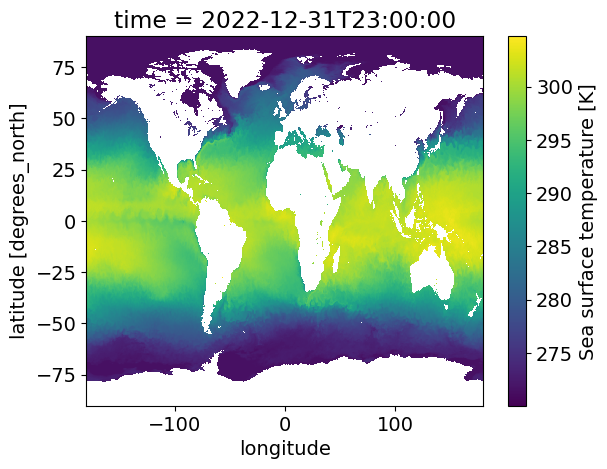

In [61]:
ds2022_winter.sst[-1].plot()

In [62]:
ds_unsorted = xr.concat([ds2018, ds2019, ds2020, ds2021, ds2022, ds2023_c.drop('expver')], dim='time')
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = ds_unsorted.sortby(ds_unsorted.latitude)

NameError: name 'ds2023_c' is not defined

In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 50309, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [13]:
180/720

0.25

In [10]:
360/1440

0.25

In [14]:
350/25

14.0

In [15]:
14/4

3.5

In [11]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 721)>
array([-90.  , -89.75, -89.5 , ...,  89.5 ,  89.75,  90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
Attributes:
    long_name:  latitude
    units:      degrees_north

### Create mask object

In [10]:
hfacc = ds.sst.where(ds.sst == ds.sst.notnull(), 999).where(ds.sst < 999, np.nan)

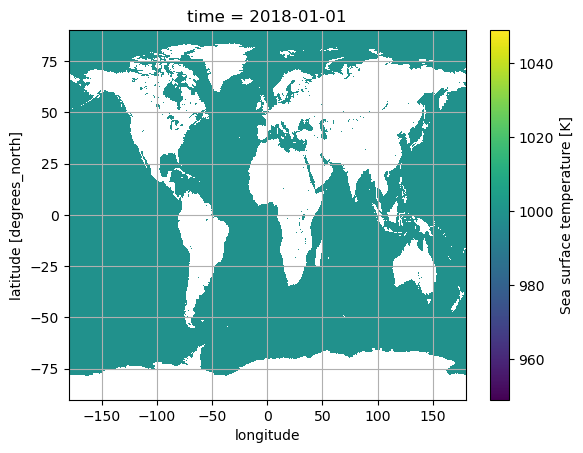

In [14]:
hfacc[0].plot()
plt.grid()

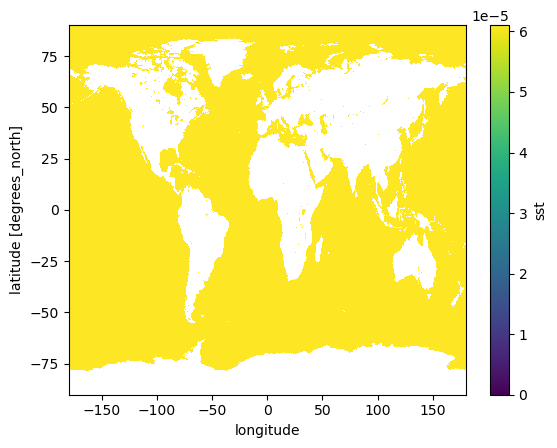

In [15]:
hfacc.std(dim='time').plot()

In [16]:
mask = hfacc[0]

In [17]:
mask

<xarray.DataArray 'sst' (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    time       datetime64[ns] 2018-01-01
Attributes:
    long_name:  Sea surface temperature
    units:      K

## Focus in on Gulf region

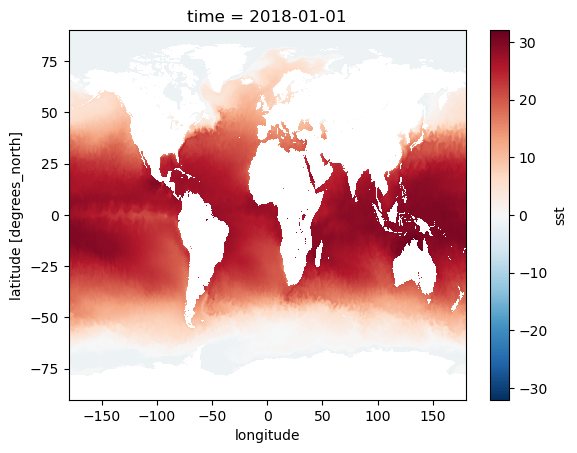

In [16]:
(ds.sst.isel(time=0) - 273.15).plot()

In [10]:
gulf = dict(longitude=slice(-100, 0), latitude=slice(8, 35))

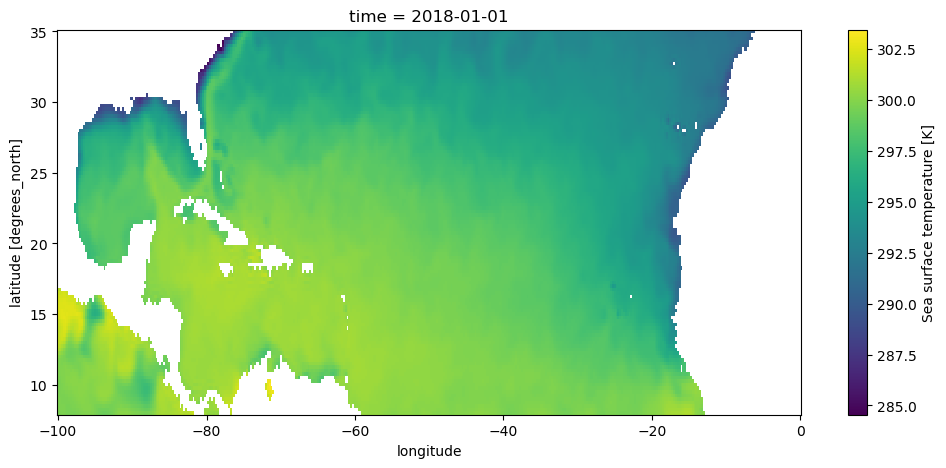

In [17]:
(ds.sst.isel(time=0).sel(**gulf)).plot(figsize=(12,5))

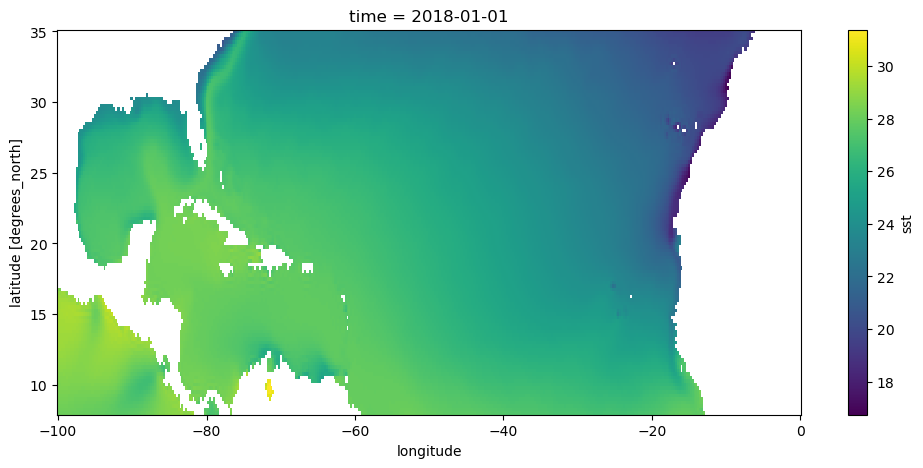

In [15]:
(ds.sst.sel(**gulf) - 273.15).mean('time').where(mask).plot(figsize=(12,5))

In [11]:
sst_trop = ds.sst.sel(**gulf) - 273.15

In [12]:
sst_trop

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<sub, shape=(50309, 109, 401), dtype=float32, chunksize=(15, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [13]:
import cmocean

Text(0.5, 1.0, 'Averaged 2018 - mid 2023 SST')

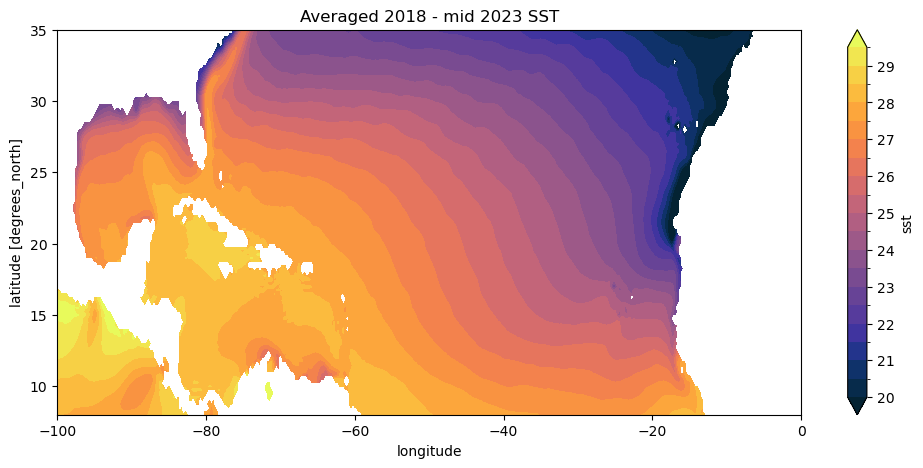

In [28]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018 - mid 2023 SST')

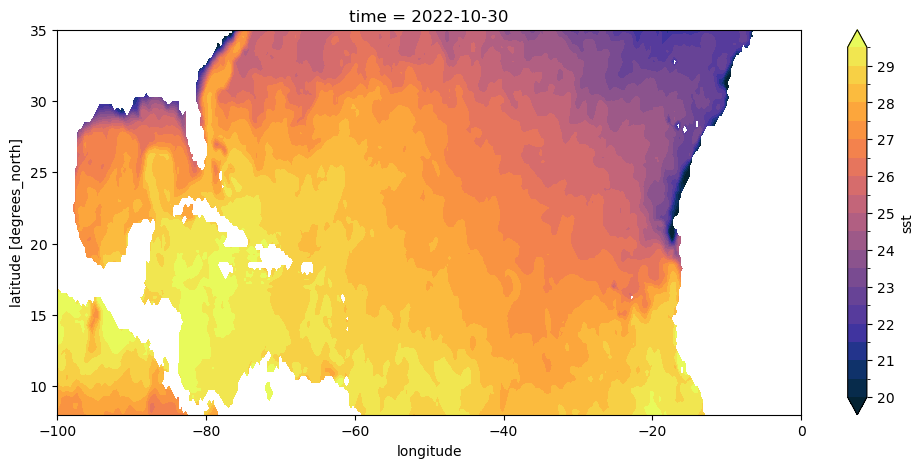

In [27]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).sel(time='2022-10-30', method='nearest').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)

## Fixed threshold

In [14]:
#daily clim
clim = sst_trop.groupby('time.dayofyear').mean('time')
clim_std = sst_trop.groupby('time.dayofyear').std('time')
anom = sst_trop.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_trop.groupby('time.month').mean('time')
mo_clim_std = sst_trop.groupby('time.month').std('time')
mo_anom = sst_trop.groupby('time.month') - mo_clim

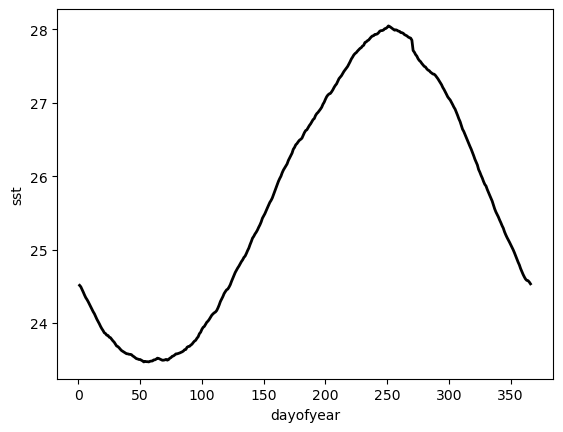

In [23]:
clim.mean(['latitude', 'longitude']).plot(color='k', linewidth=2)

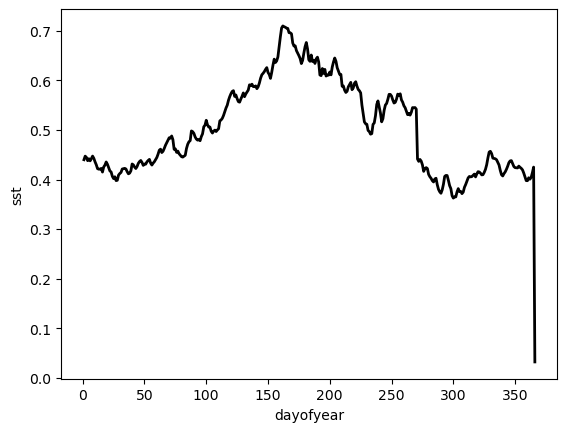

In [15]:
clim_std.mean(['latitude', 'longitude']).plot(color='k', linewidth=2)

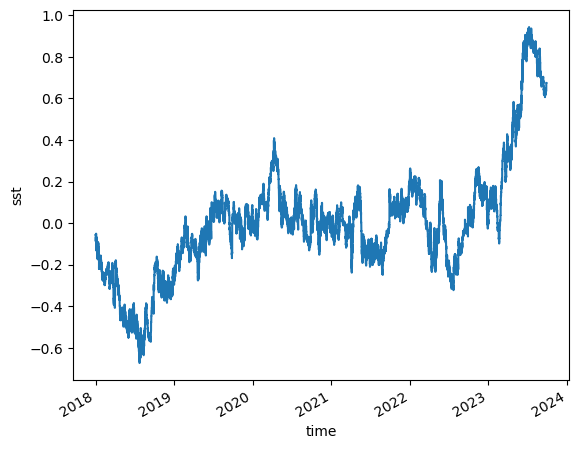

In [24]:
anom.mean(['latitude', 'longitude']).plot()

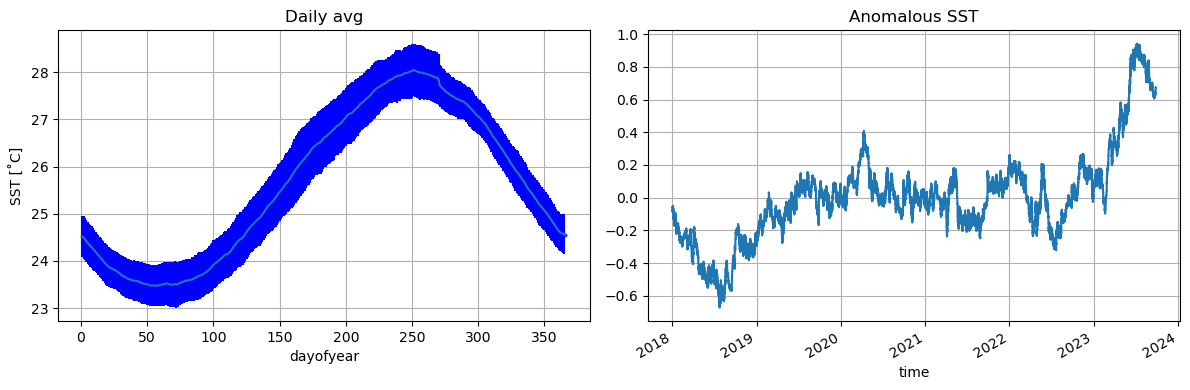

In [25]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(clim.mean(['latitude', 'longitude']).dayofyear, clim.mean(['latitude', 'longitude']), 
             yerr=clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Daily avg')
anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

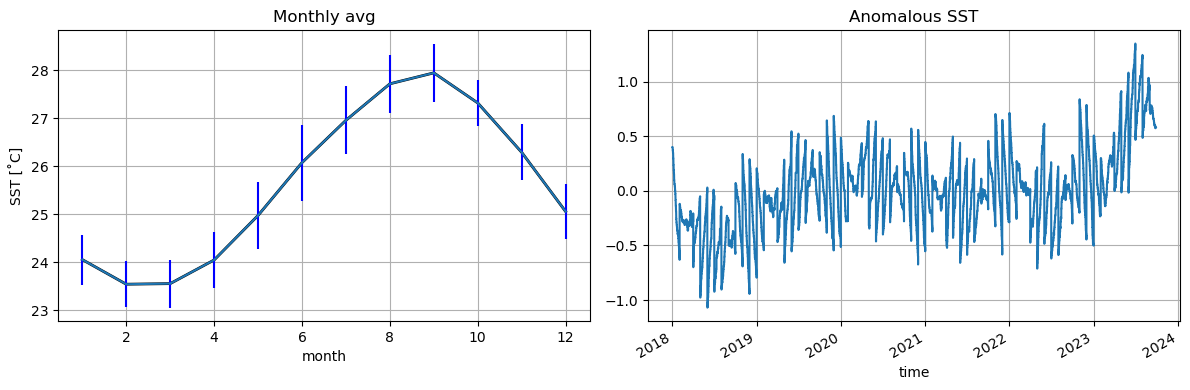

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(mo_clim.mean(['latitude', 'longitude']).month, mo_clim.mean(['latitude', 'longitude']), 
             yerr=mo_clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Monthly avg')
mo_anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

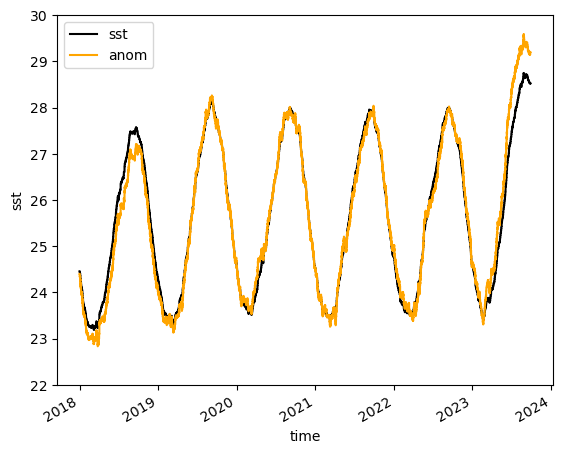

In [29]:
sst_trop.mean(['latitude', 'longitude']).plot(label='sst', color='k')
(sst_trop+anom).mean(['latitude', 'longitude']).plot(label='anom', color='orange')
plt.ylim(22,30)
plt.legend();

In [30]:
avg_sst_trop = sst_trop.mean(['latitude', 'longitude'])
avg_anom = (sst_trop+anom).mean(['latitude', 'longitude'])
hot = avg_anom.where(avg_anom > avg_sst_trop)
cold = avg_anom.where(avg_anom < avg_sst_trop)
hw = avg_anom.where(avg_anom > 27)
cs = avg_anom.where(avg_anom < 21)

In [31]:
hot

<xarray.DataArray 'sst' (time: 50309)>
dask.array<where, shape=(50309,), dtype=float32, chunksize=(15,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 270 270 270 271 271 271 271 271

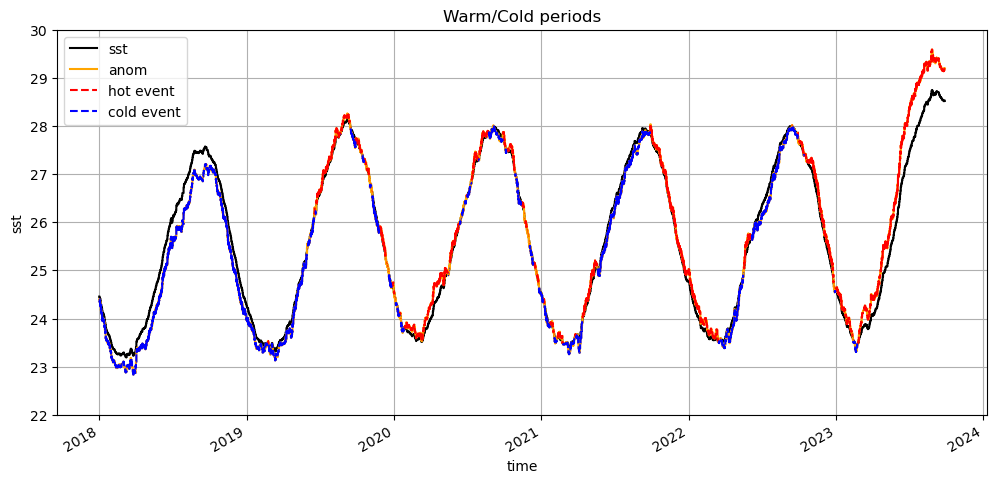

In [32]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hot.plot(label='hot event', color='red', linestyle='dashed')
cold.plot(label='cold event', color='blue', linestyle='dashed')

plt.ylim(22,30)
plt.grid()
plt.legend()
plt.title('Warm/Cold periods');

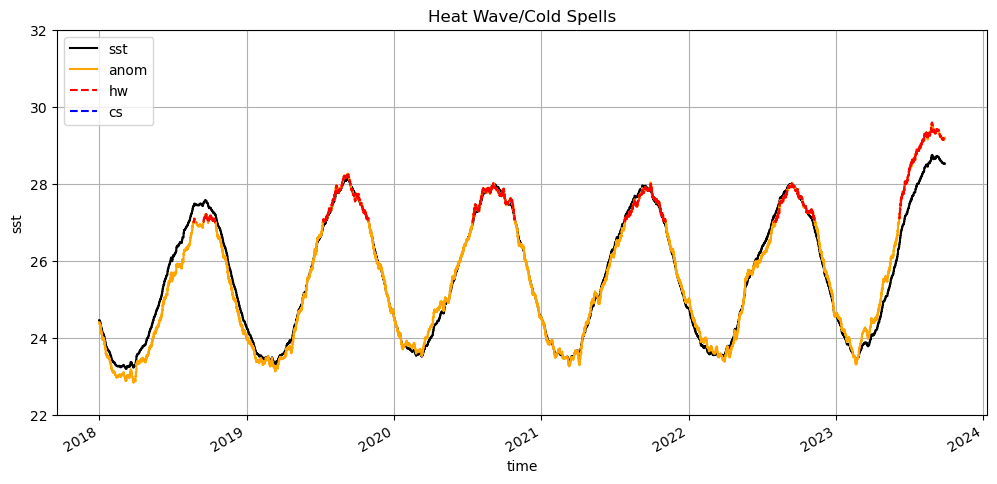

In [33]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hw.plot(label='hw', color='red', linestyle='dashed')
cs.plot(label='cs', color='blue', linestyle='dashed')

plt.ylim(22,32)
plt.grid()
plt.legend()
plt.title('Heat Wave/Cold Spells');

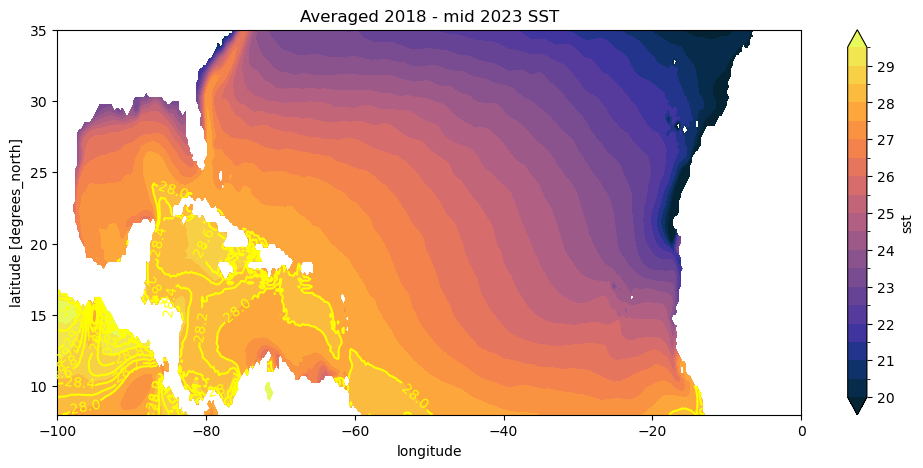

In [34]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))

C = sst_trop.mean('time').plot.contour(colors='yellow', levels=np.arange(28, 30, 0.2), ax=ax)
plt.clabel(C)

Cf = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018 - mid 2023 SST');

# Movie - ORAS5 SST

In [4]:
pot_temp = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/pt_gulf.zarr'))

In [43]:
pot_temp

<xarray.Dataset>
Dimensions:       (deptht: 75, y: 44, x: 113, time_counter: 10)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2023-01-16T12:00:00 ... 2023-...
Dimensions without coordinates: y, x
Data variables:
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 44, 113), meta=np.ndarray>

In [106]:
sst_oras5_full = pot_temp.rename_dims({'time_counter':'time'}).votemper.isel(deptht=0)
sst_oras5 = sst_oras5_full.isel(time=slice(None, -1))

In [107]:
sst_oras5

<xarray.DataArray 'votemper' (time: 9, y: 44, x: 113)>
dask.array<getitem, shape=(9, 44, 113), dtype=float32, chunksize=(1, 44, 113), chunktype=numpy.ndarray>
Coordinates:
    deptht        float32 0.5058
    nav_lat       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
  * time_counter  (time) datetime64[ns] 2023-01-16T12:00:00 ... 2023-09-16
Dimensions without coordinates: time, y, x
Attributes:
    interval_operation:  1200.0
    interval_write:      2678400.0
    long_name:           Temperature
    offline_operation:   ave(x)
    online_operation:    ave(x)
    standard_name:       Temperature
    units:               C

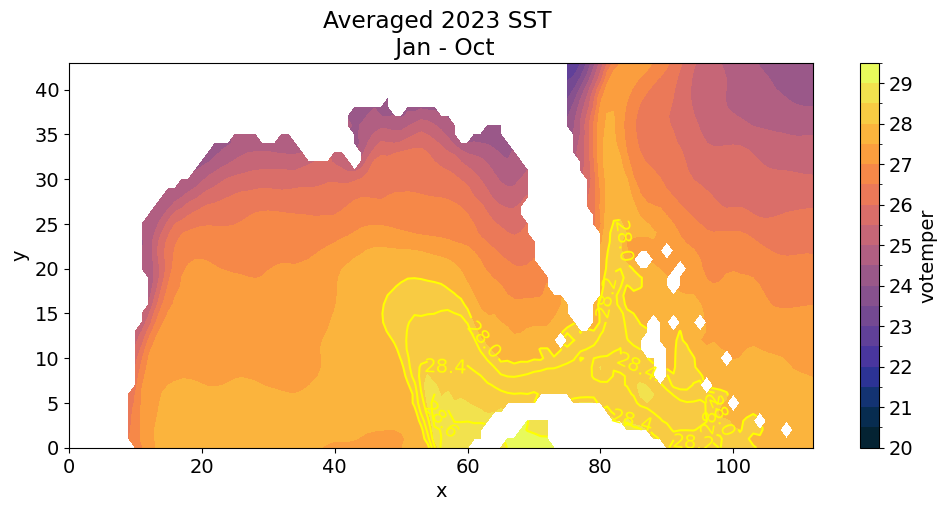

In [108]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))

C = sst_oras5.mean('time').plot.contour(colors='yellow', levels=np.arange(28, 30, 0.2), ax=ax)
plt.clabel(C)

Cf = sst_oras5.mean('time').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2023 SST \n Jan - Oct');

In [109]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [110]:
theta_levs = np.arange(20,34,0.5)

In [111]:
theta_levs[24]

32.0

In [112]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    theta_levs = np.arange(20,34,0.5)

    C = sst_oras5.isel(time=tt).plot.contour(colors='k', levels=[theta_levs[24]], ax=ax)
    #ax.clabel(C)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
    
    return ax, Cf

(<Axes: title={'center': 'deptht = 0.5058 [m], time_counter = 2023-08-16T...'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x7dd4851a9fc0>)

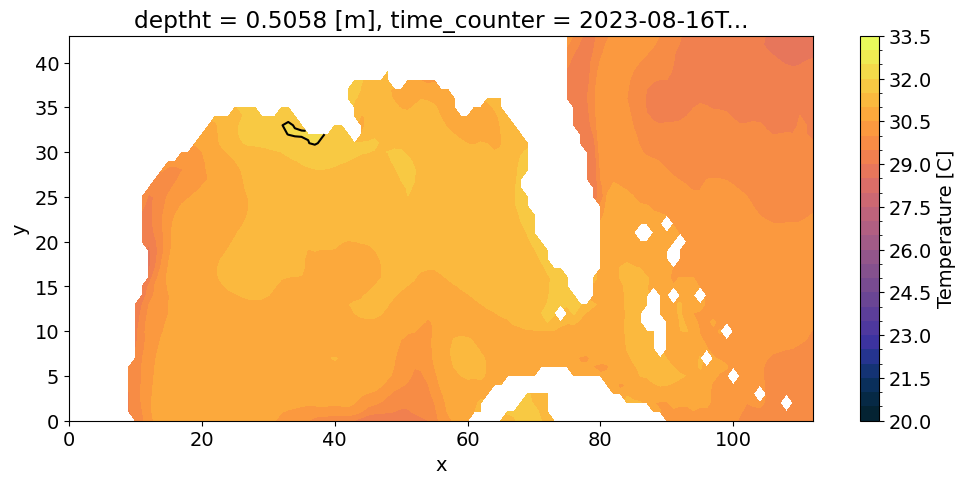

In [113]:
fig = plt.figure(figsize=(12, 5))

contour_surf(sst_oras5, fig, 7)

In [114]:
sst_obj_oras5 = Movie(sst_oras5, contour_surf, 
                   input_check=False)

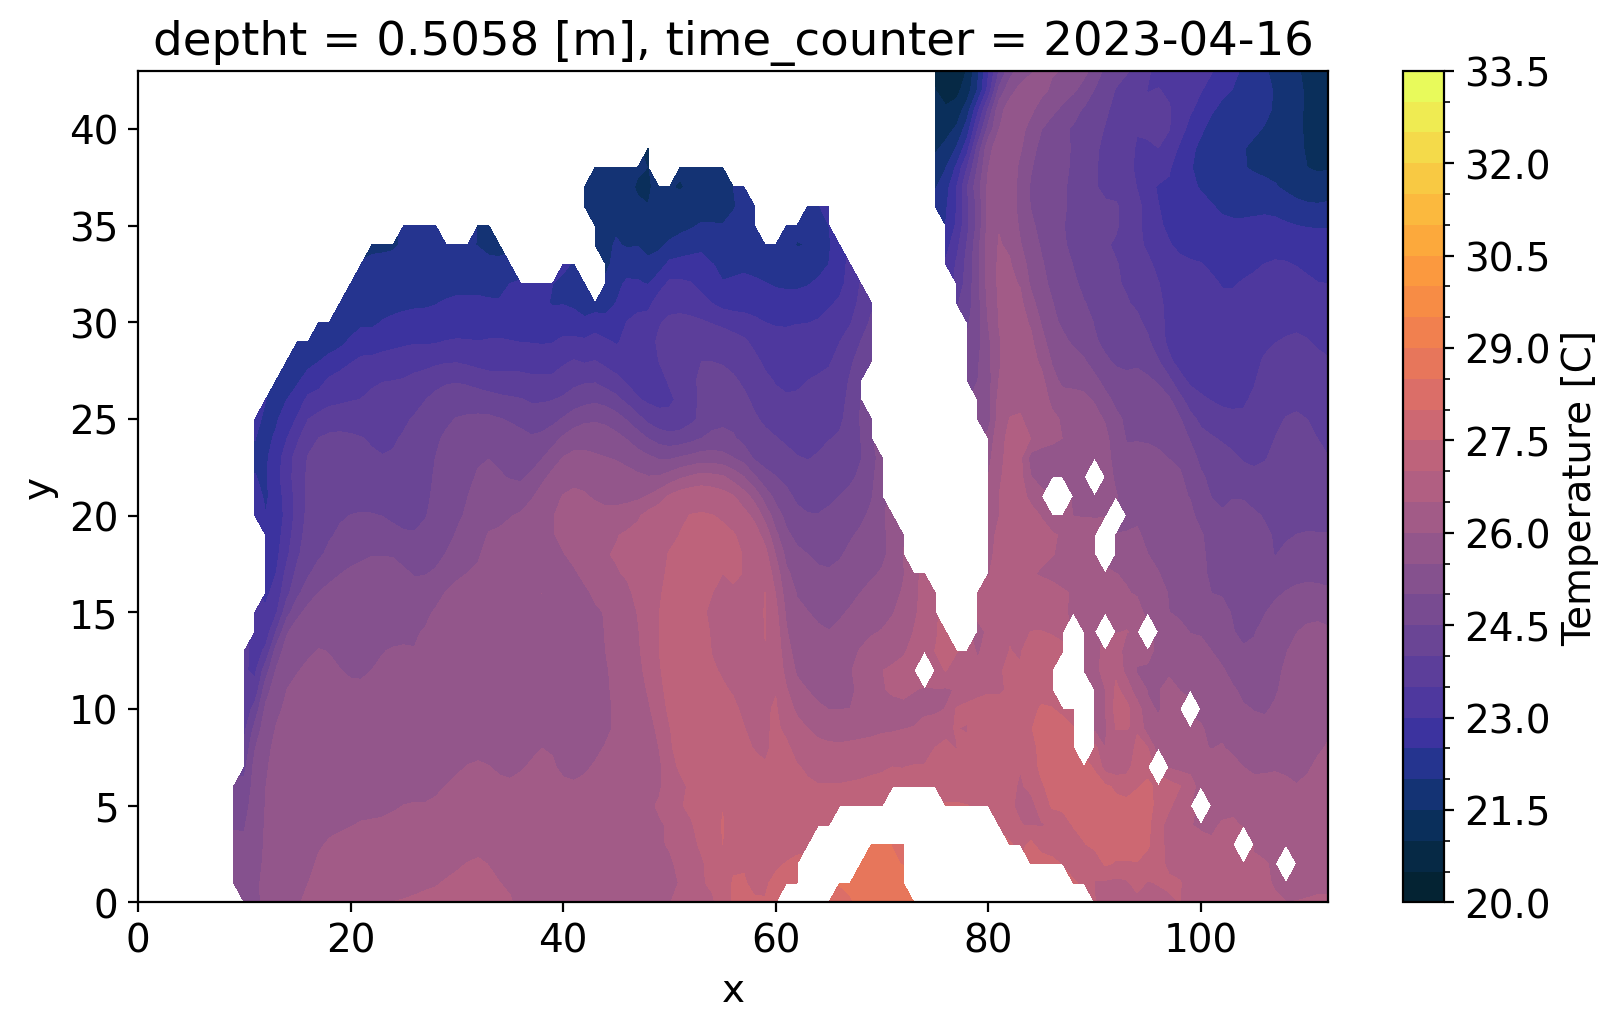

In [115]:
sst_obj_oras5.preview(3)

In [116]:
#save sstmovie
sst_obj_oras5.save('sst_oras5.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Movie created at sst_oras5.mp4


# Movie - ERA5

In [72]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [73]:
ds_sst.sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<open_dataset-sst, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [94]:
gulf = dict(longitude=slice(-100, -72), latitude=slice(22, 31))
sst_trop = ds_sst.sst.sel(**gulf)

In [95]:
resampled = sst_trop.resample(time='MS').mean()

In [96]:
resampled

<xarray.DataArray 'sst' (time: 69, latitude: 37, longitude: 113)>
dask.array<transpose, shape=(69, 37, 113), dtype=float32, chunksize=(1, 37, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2023-09-01

In [97]:
resampled.sel(time=slice('2023-01', '2023-11'))

<xarray.DataArray 'sst' (time: 9, latitude: 37, longitude: 113)>
dask.array<getitem, shape=(9, 37, 113), dtype=float32, chunksize=(1, 37, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-09-01

In [98]:
loaded_sst = resampled.sel(time=slice('2023-01', '2023-10')).compute()

In [99]:
loaded_sst

<xarray.DataArray 'sst' (time: 9, latitude: 37, longitude: 113)>
array([[[      nan,       nan,       nan, ..., 26.540987, 26.485785,
         26.296715],
        [      nan,       nan,       nan, ..., 26.61128 , 26.52971 ,
         26.473927],
        [      nan,       nan,       nan, ..., 26.58418 , 26.52197 ,
         26.513573],
        ...,
        [      nan,       nan,       nan, ..., 21.843466, 21.743877,
         21.696316],
        [      nan,       nan,       nan, ..., 21.686804, 21.643599,
         21.640125],
        [      nan,       nan,       nan, ..., 21.619514, 21.571003,
         21.556738]],

       [[      nan,       nan,       nan, ..., 25.980558, 25.93005 ,
         25.794556],
        [      nan,       nan,       nan, ..., 25.994318, 25.944403,
         25.911528],
        [      nan,       nan,       nan, ..., 25.929588, 25.92415 ,
         25.918413],
...
        [      nan,       nan,       nan, ..., 29.359785, 29.3815  ,
         29.390694],
        [      nan,       nan,       nan, ..., 29.089476, 29.143612,
         29.215082],
        [      nan,       nan,       nan, ..., 28.848484, 28.917452,
         28.967396]],

       [[      nan,       nan,       nan, ..., 30.227856, 30.232918,
         30.260359],
        [      nan,       nan,       nan, ..., 30.081417, 30.084997,
         30.08738 ],
        [      nan,       nan,       nan, ..., 30.020037, 29.993687,
         29.982775],
        ...,
        [      nan,       nan,       nan, ..., 27.706642, 27.659016,
         27.60384 ],
        [      nan,       nan,       nan, ..., 27.6277  , 27.501343,
         27.49337 ],
        [      nan,       nan,       nan, ..., 27.694454, 27.368711,
         27.24476 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-09-01

In [100]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [101]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    theta_levs = np.arange(20,34,0.5)

    C = loaded_sst.isel(time=tt).plot.contour(colors='k', levels=[theta_levs[24]], ax=ax)
    #ax.clabel(C)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
    
    return ax, Cf

(<Axes: title={'center': 'time = 2023-07-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7dd47d6a3f70>)

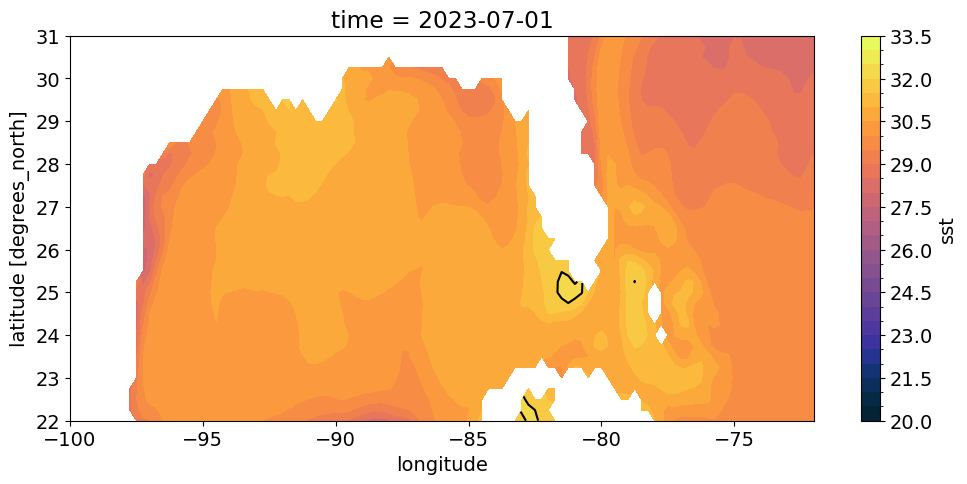

In [102]:
fig = plt.figure(figsize=(12, 5))

contour_surf(loaded_sst, fig, 6)

In [103]:
sst_era5_mo = Movie(loaded_sst, contour_surf, 
                   input_check=False)

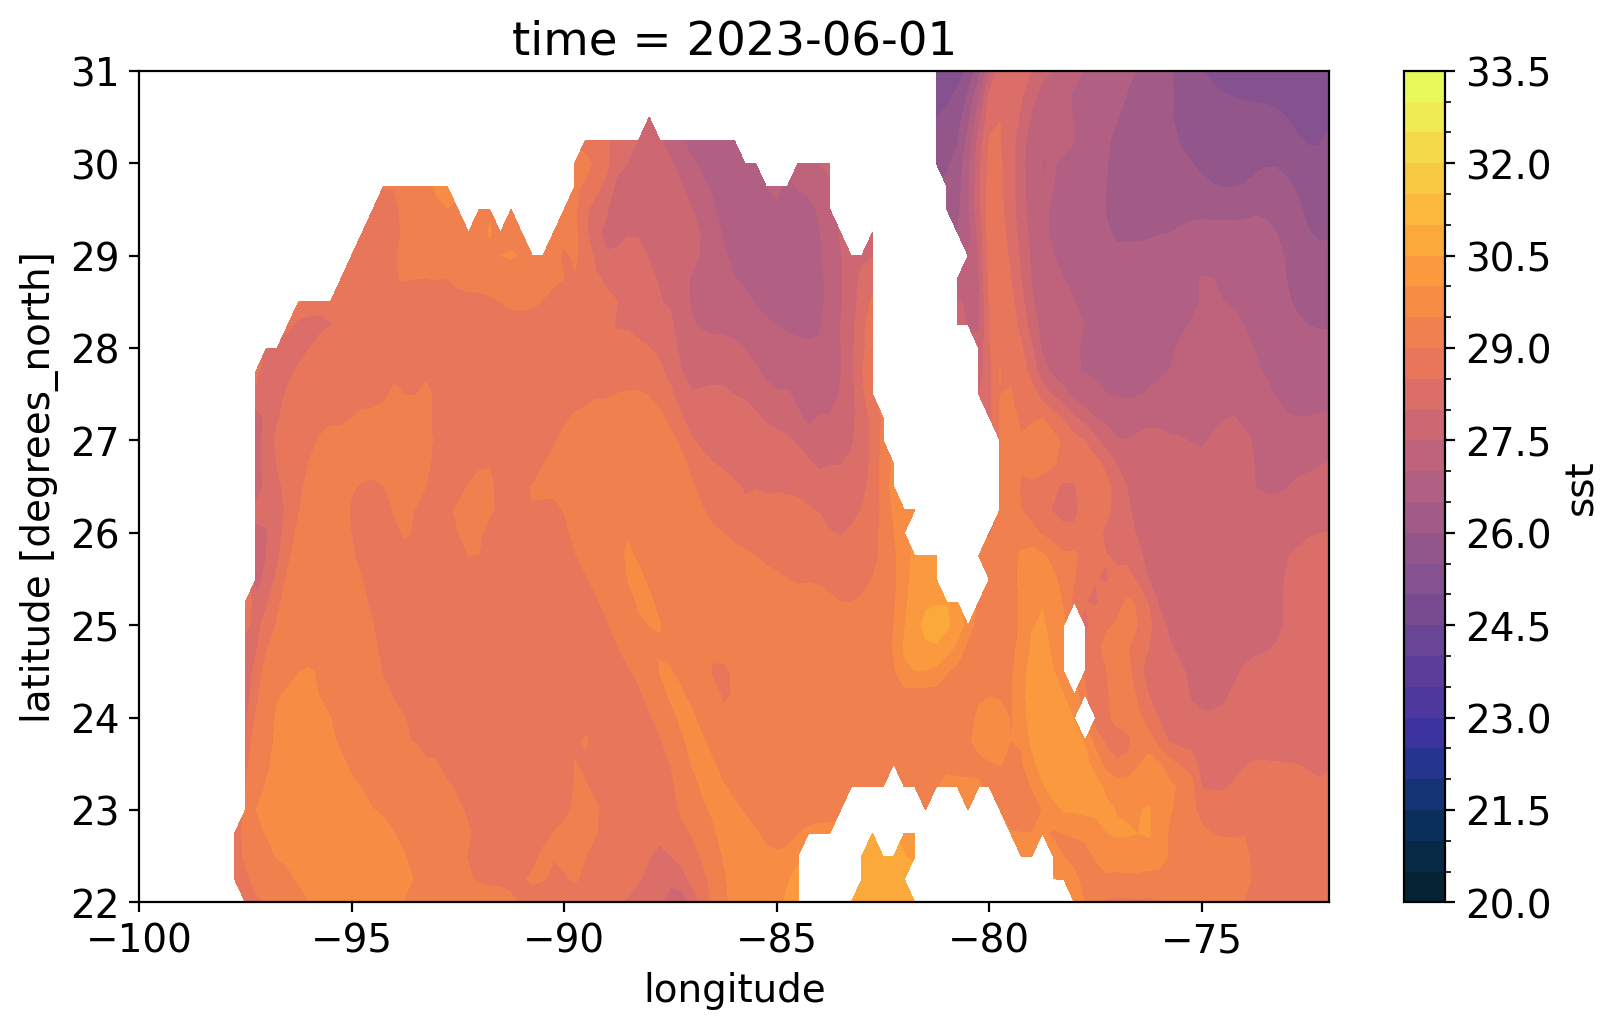

In [104]:
sst_era5_mo.preview(5)

In [105]:
#save sstmovie
sst_era5_mo.save('sst_era5_mo.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Movie created at sst_era5_mo.mp4
